In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/msk-redefining-cancer-treatment/training_text.zip

/kaggle/input/msk-redefining-cancer-treatment/stage2_test_variants.csv.7z

/kaggle/input/msk-redefining-cancer-treatment/stage1_solution_filtered.csv.7z

/kaggle/input/msk-redefining-cancer-treatment/stage2_test_text.csv.7z

/kaggle/input/msk-redefining-cancer-treatment/test_text.zip

/kaggle/input/msk-redefining-cancer-treatment/test_variants.zip

/kaggle/input/msk-redefining-cancer-treatment/stage2_sample_submission.csv.7z

/kaggle/input/msk-redefining-cancer-treatment/stage_2_private_solution.csv.7z

/kaggle/input/msk-redefining-cancer-treatment/training_variants.zip

## Import libs

In [17]:
pd.options.mode.chained_assignment = None

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rich import print
from rich.panel import Panel

#import re
#import warnings
import nltk

nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize



from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier

#Libs for one hot encoding
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer


from scipy.sparse import hstack
from collections import defaultdict
from sklearn.model_selection import train_test_split
import math

#Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV



[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


## Read data into dataframes:


In [19]:
data = pd.read_csv('/kaggle/input/msk-redefining-cancer-treatment/training_variants.zip')
text_data = pd.read_csv("/kaggle/input/msk-redefining-cancer-treatment/training_text.zip",sep="\|\|",names=["ID","Text"],skiprows=1)

/tmp/ipykernel_33/2907953934.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  text_data = pd.read_csv("/kaggle/input/msk-redefining-cancer-treatment/training_text.zip",sep="\|\|",names=["ID","Text"],skiprows=1)


## Display data in dataframes

In [20]:
#Gene Variation and Class dataframe:
print(f"Gene, Variation pair with Class has {data.shape[0]} Rows, {data.shape[1]} Columns")
data.head()


Gene, Variation pair with Class has 3321 Rows, 4 Columns

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [21]:
#Each Gene,Variation pair has a unique ID, with text accompanying it's profile which will help in the classifying
print(f"{data.shape[0]} Rows, {data.shape[1]} Columns")
print('Features: ', text_data.columns.values)
print(text_data.head())

3321 Rows, 4 Columns

Features:  ['ID' 'Text']

ID                                               Text
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...

In [22]:
#Left join on ID to consolidate into one df
final_df = pd.merge(data, text_data, on='ID', how='left')
print(f"{final_df.shape[0]} rows...... {final_df.shape[1]} Columns in final_df")
final_df.head()

3321 rows...... 5 Columns in final_df

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [23]:
# Dynamic information
unique_genes_count = len(final_df['Gene'].unique())
unique_variations_count = len(final_df['Variation'].unique())
unique_classes = final_df['Class'].unique()

data_panel = Panel.fit(
    f"""[bold]Dataset Summary[/bold]

- [cyan]Unique set of Genes in the feature set:[/cyan] [green]{unique_genes_count}[/green]
- [cyan]Unique set of Variations in the feature set:[/cyan] [green]{unique_variations_count}[/green]
- [cyan]The set of classes that are unique in the dataset:[/cyan] [green]{unique_classes}[/green]
    """, title="Data Information")

# Print the panel
print(data_panel)

╭──────────────────────────── Data Information ────────────────────────────╮
│ Dataset Summary                                                          │
│                                                                          │
│ - Unique set of Genes in the feature set: 264                            │
│ - Unique set of Variations in the feature set: 2996                      │
│ - The set of classes that are unique in the dataset: [1 2 3 4 5 6 7 8 9] │
│                                                                          │
╰──────────────────────────────────────────────────────────────────────────╯

## Data Quality and Completeness check

In [24]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
 4   Text       3316 non-null   object
dtypes: int64(2), object(3)
memory usage: 129.9+ KB


In [25]:
print('Number of unique amino acid variations :', len(data['Variation'].unique()))
print ('Number of unique genes:', len(data['Gene'].unique()))

Number of unique amino acid variations : 2996

Number of unique genes: 264

## Text Column Pre-processing

In [26]:
#remove stop words
stop_words = set(stopwords.words('english'))

In [27]:
def text_preprocessing(text):
    if isinstance(text, str):
        # Replace special characters with space
        text = re.sub('[^a-zA-Z0-9\n]', ' ', text)
        # Replace multiple spaces with a single space
        text = re.sub('\s+',' ', text)
        # Convert all the chars into lower-case
        text = text.lower()

        # Tokenize the sentence into a list of words
        words = word_tokenize(text)

        # List of context specific words that can be neglected
        irrelevant_words = {'et', 'al'}
        
        #Remove stop words  
        final_words = [word for word in words if word not in stop_words and word not in irrelevant_words]]

        # Join the filtered words back into a string
        final_text = ' '.join(final_words)

        return final_text

SyntaxError: unmatched ']' (1136325739.py, line 17)

In [ ]:
# apply text_processing function to Text feature containing abstracts
final_df['Text'] = final_df['Text'].apply(lambda x: text_preprocessing(x) if isinstance(x, str) else x)

In [ ]:
#Check
final_df.head()

## Train and Test Splitting the dataframe

In [ ]:
#80/20 trainining and testing split. Stratify the data for the target 'Class' 
init_train_df, test_df = train_test_split(final_df, test_size=0.2, stratify=final_df['Class'])


In [ ]:
# Split the train data into train and cross-validation sets while maintaining the same distribution of the 'Class' column
train_df, cv_df = train_test_split(init_train_df, test_size=0.2, stratify=init_train_df['Class'])

In [ ]:
# Target feature dataframe set-up

# Establish the single Target feauture to be a numpy array and not a dataframe--hence the use of .values
y_train = train_df['Class'].values
y_cv = cv_df['Class'].values
y_test = test_df['Class'].values

In [ ]:
#These can remain as dataframes for now as they will encoded
x_train = train_df.drop(columns=['Class'])
x_cv = cv_df.drop(columns=['Class'])
x_test = test_df.drop(columns=['Class'])

# Probability encoding features for random forest:

## Part 1. Prob encode the ['Gene']['Variation'] feature columns

In [ ]:
# Use a smoothing factor (integer) to handle 0 probs

def extract_response_coding_probs(alpha, feature, df):
    total_classes = 9
    # Group the df by the feature and Class cloumns and get counts for feature given Class pair (numerator)
    grouped = df.groupby([feature, 'Class']).size().reset_index(name='count')
    # .size() of the groupby returns the total count, which includes NaN
    # .count() does not
    
    response_code_probs = {}
    feature_counts = df[feature].value_counts().to_dict()
    
    # Why not just convert this into a dataframe too? using reset_index()
    # Accessing values using dict comprehension is are more faster and efficient 
    # unlike dataframes which would need elaborate location indicator for the values
    
    for value in feature_counts:
        value_group = grouped[grouped[feature] == value]
        class_probs = []
        for k in range(1, total_classes + 1):
            # Check if the current class exists for the current feature value
            if k in value_group['Class'].values:
                count = value_group[value_group['Class'] == k]['count'].values[0]
            else:
                count = 0

            numerator = count + alpha
            denominator = feature_counts[value] + total_classes * alpha
            class_probs.append(numerator / denominator)
        response_code_probs[value] = class_probs

    return response_code_probs

In [ ]:
def generate_response_coded_feature(feature, df, response_code_probs):
    total_classes = 9
    default_prob = [1 / total_classes] * total_classes

    # Use the map() method to map the values of the feature column to the corresponding probabilities.
    # The get() method on the response_code_probs dictionary allows you to specify the default_prob as a fallback.
    
    response_coded_feature = df[feature].map(lambda x: response_code_probs.get(x, default_prob))

    return response_coded_feature.tolist()

### Prob Encode Gene feature col:

In [ ]:
alpha = 1

gene_dict = extract_response_coding_probs(alpha, 'Gene', train_df)

# Train the Gene feature
train_gene_rc = np.array(generate_response_coded_feature("Gene", train_df, gene_dict))
# Test the Gene feature
test_gene_rc = np.array(generate_response_coded_feature("Gene", test_df, gene_dict))
# Cross validate the Gene feature
cv_gene_rc = np.array(generate_response_coded_feature("Gene", cv_df, gene_dict))

### Prob Encode Variation col

In [ ]:
variation_dict=extract_response_coding_probs(alpha, 'Variation', train_df)

# Train the Variation feature
train_variation_rc = np.array(generate_response_coded_feature("Variation", train_df, variation_dict))
# Test the Variation feature
test_variation_rc = np.array(generate_response_coded_feature("Variation", test_df, variation_dict))
# Cross validate the Variation feature
cv_variation_rc = np.array(generate_response_coded_feature("Variation", cv_df, variation_dict))

### Part 2. Prob encode the Text feature

In [ ]:
from collections import Counter

In [ ]:
def extract_counter(cls_text):
    
    cls_text['Text'] = cls_text['Text'].astype(str).fillna('')
        
    # Use the apply() method to split each row's 'TEXT' into a list of words and then concatenate those lists
    all_words = cls_text['Text'].apply(lambda x: x.split()).explode().tolist()
 
    # Use the Counter() method to count the occurrences of each word
    word_count = Counter(all_words)
 
    return word_count

In [ ]:
dict_list = []
# dict_list is a list containing 9 dictionaries, each corresponding to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    dict_list.append(extract_counter(cls_text))

# total_dict is built on the entire training text data
total_dict = extract_counter(train_df)

### Top 10 words per class

In [ ]:
# Function to extract top N words for each class
def extract_top_words_per_class(cls_text, top_n=20):
    cls_text['Text'] = cls_text['Text'].astype(str).fillna('')
    all_words = cls_text['Text'].apply(lambda x: x.split()).explode().tolist()
    word_count = Counter(all_words)
    return word_count.most_common(top_n)

In [ ]:
# Flatten the dict_list to create a DataFrame for plotting
dict_list_top_words = []
for i in range(1, 10):
    cls_text = train_df[train_df['Class'] == i]
    top_words = extract_top_words_per_class(cls_text)
    dict_list_top_words.append(top_words)


In [ ]:
# Flatten the dict_list_top_words to create a DataFrame for plotting
data_for_plot = []
for class_idx, top_words in enumerate(dict_list_top_words, start=1):
    total_words_in_class = sum([count for word, count in top_words])
    for word, count in top_words:
        data_for_plot.append({
            'Class': f'Class {class_idx}',
            'Word': word,
            'Frequency': count / total_words_in_class * 100  # Normalize to percentage
        })

df_plot = pd.DataFrame(data_for_plot)

# Create the plot
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")

# Create a barplot
g = sns.catplot(
    x='Frequency', y='Word', hue='Class', data=df_plot,
    kind='bar', height=8, aspect=2, palette='tab10', dodge=True
)

# Customize the plot
g.despine(left=True)
g.set_titles("Top 10 Most Common Words in Each Class")
g.set_axis_labels("Word Frequency (%)", "Words")
plt.title("Top 10 Most Common Words in Each Class", fontsize=16)
plt.xticks(rotation=45)

# Display the plot
plt.show()


In [ ]:
# Function to print the top N most common words
def print_top_n_words(word_count_dict, n=5):
    top_n_words = word_count_dict.most_common(n)
    for word, count in top_n_words:
        print(f"{word}: {count}")

# Print limited output
print("Word counts per class:")
for idx, d in enumerate(dict_list, start=1):
    print(f"Class {idx}:")
    print_top_n_words(d, n=5)

print("Total word counts:")
print_top_n_words(total_dict, n=5)

In [ ]:
def generate_text_responsecoding(df, dict_list, total_dict, alpha):
    num_classes = 9  # Number of classes
    num_rows = df.shape[0]  # Number of rows in the DataFrame

    # Initialize a zeros array with shape (num_rows, num_classes)
    text_feature_rc = np.zeros((num_rows, num_classes))

    # Split the Text column into lists of words
    df['split_text'] = df['Text'].apply(lambda x: x.split())

    # Calculate response coding for each class
    for i in range(num_classes):
        row_index = 0
        for split_text in df['split_text']:
            # Use list comprehension and the map() method to apply the log probability calculations
            sum_prob = sum(
                map(
                    lambda word: math.log((dict_list[i].get(word, 0) + alpha) / (total_dict.get(word, 0) + 9*alpha)),
                    split_text
                )
            )
            # Calculate the final value for each row and class
            text_feature_rc[row_index, i] = math.exp(sum_prob / len(split_text))
            row_index += 1
 
            df.drop(['split_text'], axis=1)
           
    return text_feature_rc

In [ ]:
alpha = 10

train_text_rc  = generate_text_responsecoding(train_df, dict_list, total_dict, alpha)
test_text_rc  = generate_text_responsecoding(test_df, dict_list, total_dict, alpha)
cv_text_rc  = generate_text_responsecoding(cv_df, dict_list, total_dict, alpha)

In [ ]:
featured_counts = final_df['Gene'].value_counts().to_dict()

## Stack Features

In [ ]:
train_gene_var_rc = np.hstack((train_gene_rc, train_variation_rc))
test_gene_var_rc = np.hstack((test_gene_rc, test_variation_rc))
cv_gene_var_rc = np.hstack((cv_gene_rc, cv_variation_rc))

train_x_rc = np.hstack((train_gene_var_rc, train_text_rc))
test_x_rc = np.hstack((test_gene_var_rc, test_text_rc))
cv_x_rc = np.hstack((cv_gene_var_rc, cv_text_rc))

train_y = np.array(list(train_df['Class']))
test_y = np.array(list(test_df['Class']))
cv_y = np.array(list(cv_df['Class']))

## Training Random Forest

In [ ]:
#using scikit
def train_and_evaluate_model(train_x, train_y, cv_x, cv_y, n_estimators, max_depth):
    clf = RandomForestClassifier(n_estimators=n_estimators, criterion='gini', max_depth=max_depth, random_state=42, n_jobs=-1)
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
    sig_clf.fit(cv_x, cv_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x)
    return log_loss(cv_y, sig_clf_probs, labels=clf.classes_)

In [ ]:
# Lists of alpha and max_depth values
alpha = [10, 50, 100, 200, 500, 1000]
max_depth = [2, 3, 5, 10] 

In [ ]:
# Create a grid of all possible combinations of alpha and max_depth
param_grid = [(i, j) for i in alpha for j in max_depth]

In [ ]:
# Evaluate all combinations
log_errors = [train_and_evaluate_model(train_x_rc, train_y, cv_x_rc, cv_y, i, j) for i, j in param_grid]

# Find the combination with the lowest log loss
min_log_error = min(log_errors)
best_params_index = log_errors.index(min_log_error)
best_alpha, best_max_depth = param_grid[best_params_index]

# Final Training

In [ ]:
# Train the final model with the best parameters
final_clf = RandomForestClassifier(n_estimators=best_alpha, criterion='gini', max_depth=best_max_depth, random_state=42, n_jobs=-1)
final_clf.fit(train_x_rc, train_y)
final_sig_clf = CalibratedClassifierCV(final_clf, method="sigmoid",cv="prefit")
final_sig_clf.fit(cv_x_rc, cv_y)

# Evaluate the final model
def evaluate_final_model(data_x, data_y, message):
    predict_y = final_sig_clf.predict_proba(data_x)
    print(f'For values of best alpha = {best_alpha}, best max depth = {best_max_depth}, {message} log loss is:', log_loss(data_y, predict_y, labels=final_clf.classes_, eps=1e-15))

evaluate_final_model(train_x_rc, y_train, 'train')
evaluate_final_model(cv_x_rc, y_cv, 'cross validation')
evaluate_final_model(test_x_rc, y_test, 'test')

# Predictions from test:

In [ ]:
test_predictions = final_sig_clf.predict(test_x_rc)

## Accuracy, Confusion/Recall/Precision plots:

In [ ]:
def plot_class_accuracy(test_y, predict_y):
    # Compute the confusion matrix
    C = confusion_matrix(test_y, predict_y)
    labels = np.unique(test_y)  # Ensure labels are based on actual classes in test_y
    
    # Calculate accuracy for each class
    accuracy_per_class = C.diagonal() / C.sum(axis=1)
    
    # Create a DataFrame for plotting
    accuracy_df = pd.DataFrame({
        'Class': labels,
        'Accuracy': accuracy_per_class * 100  # Convert to percentage
    })
    
    # Plot the accuracy per class
    plt.figure(figsize=(12, 7))
    sns.barplot(x='Class', y='Accuracy', data=accuracy_df, palette='viridis')
    plt.title('Accuracy per Class')
    plt.xlabel('Class')
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100)
    
    # Add labels on top of the bars
    for index, row in accuracy_df.iterrows():
        plt.text(row.name, row.Accuracy + 1, f'{row.Accuracy:.2f}%', color='black', ha="center")
    
    plt.show()


In [28]:
def plot_heatmap(matrix, labels, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    labels = np.unique(test_y)  # Ensure labels are based on actual classes in test_y

    # Calculate the recall matrix
    recall_matrix = C / C.sum(axis=1, keepdims=True)

    # Calculate the precision matrix
    precision_matrix = C / C.sum(axis=0, keepdims=True)

    # Plot the confusion matrix
    plot_heatmap(C, labels, "Confusion matrix")

    # Plot the precision matrix
    plot_heatmap(precision_matrix, labels, "Precision matrix (sum of elements in a column=1)")

    # Plot the recall matrix
    plot_heatmap(recall_matrix, labels, "Recall matrix (sum of elements in a row=1)")
    
    # Plot the accuracy per class
    plot_class_accuracy(test_y, predict_y)

/tmp/ipykernel_33/4166328434.py:17: RuntimeWarning: invalid value encountered in divide
  precision_matrix = C / C.sum(axis=0, keepdims=True)


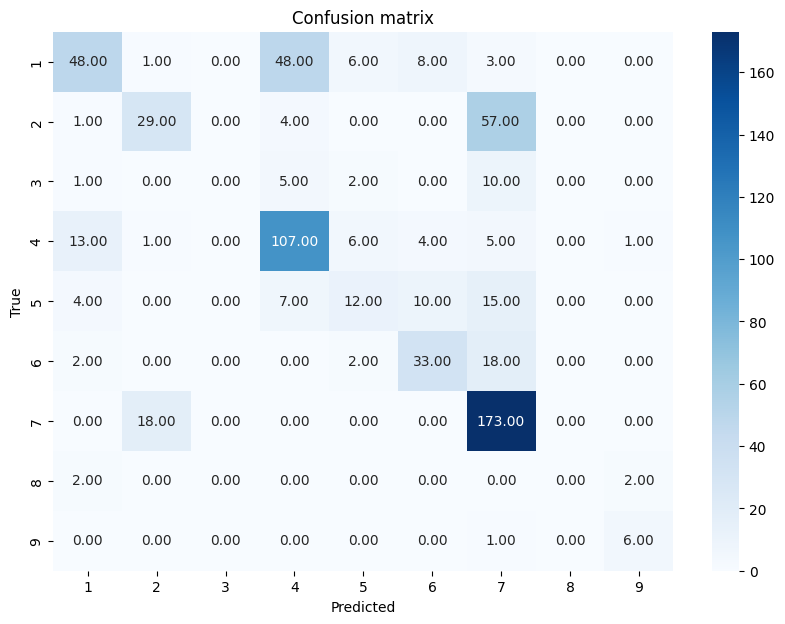

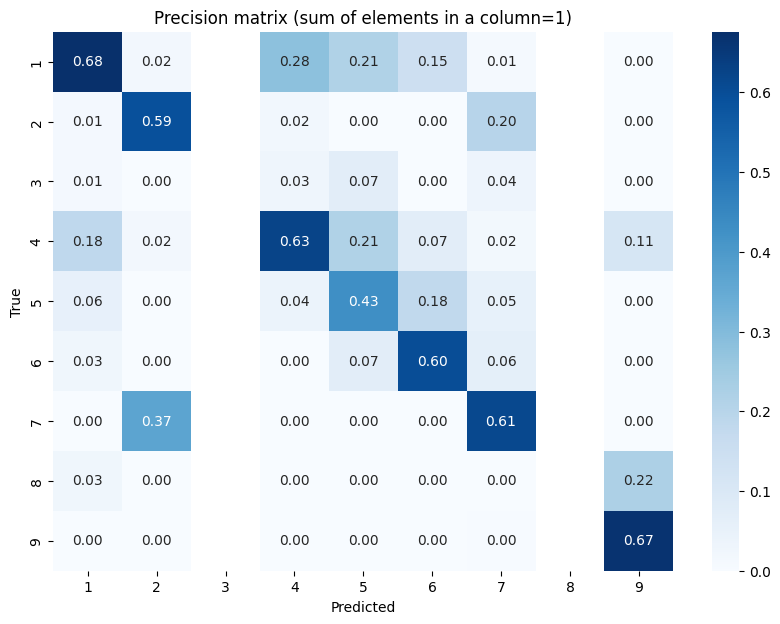

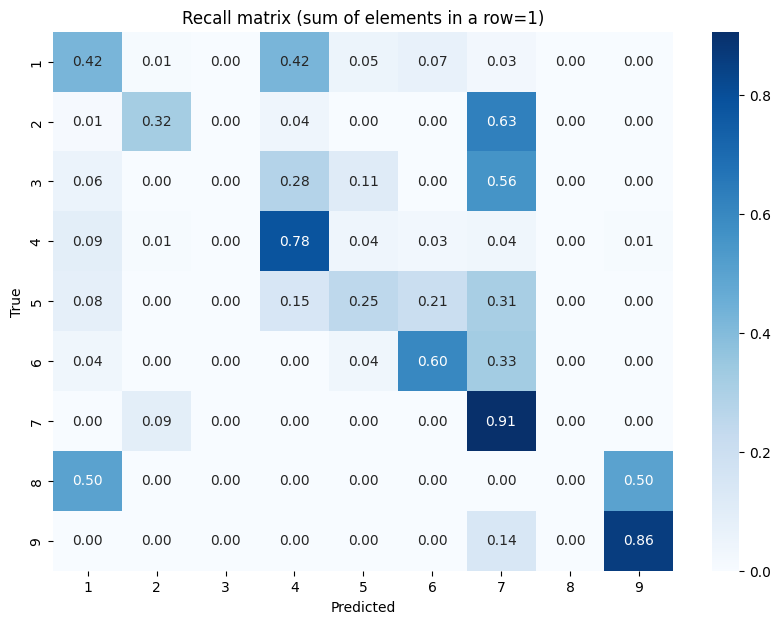

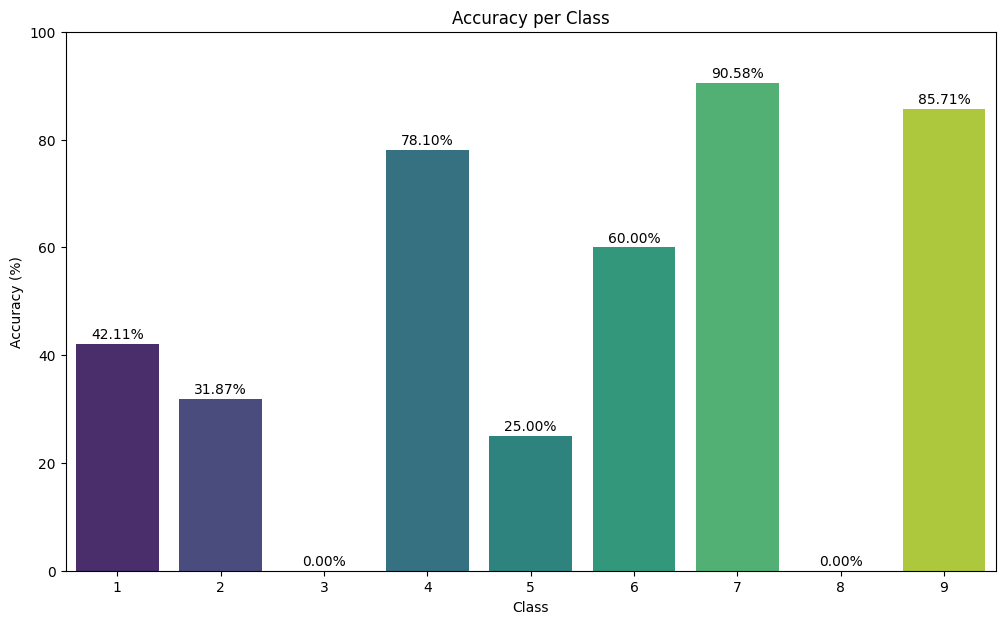

In [29]:
plot_confusion_matrix(y_test, test_predictions)

# Check classes in actual dataset

Proportion of each class in the test set:

Class
7    28.721805
4    20.601504
1    17.142857
2    13.684211
6     8.270677
5     7.218045
3     2.706767
9     1.052632
8     0.601504
Name: proportion, dtype: float64

Proportion of class 3 in the test set: 2.71%

Proportion of class 8 in the test set: 0.60%

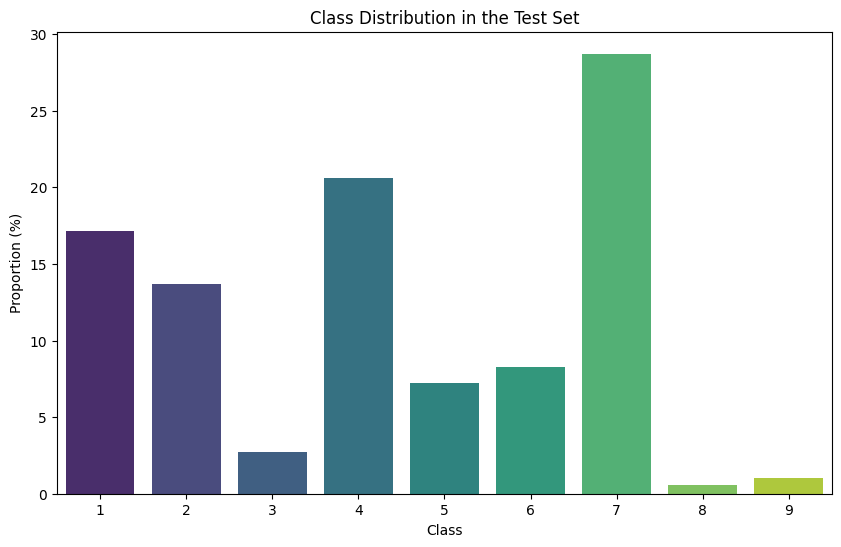

In [30]:
# Create a DataFrame to analyze the class distribution
test_class_distribution = pd.DataFrame(y_test, columns=['Class'])

# Calculate the proportion of each class in the test set
class_counts = test_class_distribution['Class'].value_counts(normalize=True) * 100

# Print the proportions
print("Proportion of each class in the test set:")
print(class_counts)

# Specifically check proportions for classes 3 and 8
print("\nProportion of class 3 in the test set: {:.2f}%".format(class_counts.get(3, 0)))
print("Proportion of class 8 in the test set: {:.2f}%".format(class_counts.get(8, 0)))

# Optionally, visualize the class distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Class Distribution in the Test Set')
plt.xlabel('Class')
plt.ylabel('Proportion (%)')
plt.show()


## XGboost

In [31]:
import xgboost as xgb
from sklearn.metrics import log_loss, accuracy_score
import numpy as np

# Prepare the data (assuming this is done already and you have train_x_rc, train_y, cv_x_rc, cv_y, test_x_rc, y_test)

# Convert data to DMatrix, which is a data structure optimized for XGBoost
dtrain = xgb.DMatrix(train_x_rc, label=train_y)
dvalid = xgb.DMatrix(cv_x_rc, label=cv_y)
dtest = xgb.DMatrix(test_x_rc, label=y_test)

# Set parameters for XGBoost
params = {
    'objective': 'multi:softprob',  # Multi-class classification
    'num_class': len(np.unique(train_y)),  # Number of classes
    'max_depth': 5,  # Maximum depth of trees
    'eta': 0.1,  # Learning rate
    'subsample': 0.8,  # Subsample ratio of the training instances
    'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
    'seed': 42  # Random seed
}

In [32]:
# Train the model
evallist = [(dtrain, 'train'), (dvalid, 'eval')]
num_round = 100
bst = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=10)

# Predict probabilities on validation set
valid_preds = bst.predict(dvalid)

# Calculate log loss on validation set
valid_log_loss = log_loss(cv_y, valid_preds)
print(f'Validation Log Loss: {valid_log_loss}')

# Predict probabilities on test set
test_preds_XG = bst.predict(dtest)

# Calculate log loss on test set
test_log_loss = log_loss(y_test, test_preds_XG)
print(f'Test Log Loss: {test_log_loss}')

# Predict the labels (classes) on test set
test_predictions = np.argmax(test_preds_XG, axis=1)


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


XGBoostError: [15:05:11] /workspace/src/objective/multiclass_obj.cu:123: SoftmaxMultiClassObj: label must be in [0, num_class).
Stack trace:
  [bt] (0) /opt/conda/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x1ba24e) [0x78fe635dc24e]
  [bt] (1) /opt/conda/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0xa60e7f) [0x78fe63e82e7f]
  [bt] (2) /opt/conda/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x490492) [0x78fe638b2492]
  [bt] (3) /opt/conda/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x4c5488) [0x78fe638e7488]
  [bt] (4) /opt/conda/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x78fe63583ef0]
  [bt] (5) /opt/conda/lib/python3.10/lib-dynload/../../libffi.so.8(+0x6a4a) [0x78ff41d6ca4a]
  [bt] (6) /opt/conda/lib/python3.10/lib-dynload/../../libffi.so.8(+0x5fea) [0x78ff41d6bfea]
  [bt] (7) /opt/conda/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x12461) [0x78ff41d84461]
  [bt] (8) /opt/conda/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x86eb) [0x78ff41d7a6eb]



In [33]:
# Calculate accuracy
test_accuracy = accuracy_score(y_test, test_predictions)
print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.6135338345864662